In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

ModuleNotFoundError: No module named 'nltk'

In [ ]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_text(alltext, bigrams=True):
    alltext = alltext.lower() # lower case
    alltext = re.sub('['+my_punctuation + ']+', ' ', alltext) # strip punctuation
    alltext = re.sub('\s+', ' ', alltext) #remove double spacing
    alltext_token_list = [word for word in alltext.split(' ')
                            if word not in my_stopwords] # remove stopwords

    alltext_token_list = [word_rooter(word) if '#' not in word else word
                        for word in alltext_token_list] # apply word rooter
    if bigrams:
        alltext_token_list = alltext_token_list+[alltext_token_list[i]+'_'+alltext_token_list[i+1]
                                            for i in range(len(alltext_token_list)-1)]
    alltext = ' '.join(alltext_token_list)
    return alltext

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [3]:
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pickle
from joblib import Memory

c:\Users\saura\anaconda3\envs\cdl-env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
expenses = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\IDS-DRR-Assam\Sources\SDRF\data\flood_expenses_RCgeotagged_1.csv')
expenses['analysis_text'] = expenses['Name of the Scheme'] + ' ' + expenses['Brief nature of the scheme'] + ' ' + expenses['Aim, objectives and benefit expected from the scheme/project']
expenses_cleaned = expenses[expenses['analysis_text'].notnull()]
data = expenses_cleaned['analysis_text']

In [ ]:
#expenses['text'] = data.alltext.apply(clean_text)
#data

In [50]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings = model.encode(data.tolist(), show_progress_bar=True)
df_1 = expenses_cleaned.iloc[:len(expenses_cleaned)//2] # Half of the data
embeddings_1 = embeddings[:embeddings.shape[0] // 2, :] # Half of the embeddings

c:\Users\saura\anaconda3\envs\cdl-env\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/163 [00:00<?, ?it/s]

In [51]:

umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(embeddings_1)

umap_2d = umap.UMAP(n_neighbors=15,
                    n_components=2,
                    min_dist=0.0,
                    metric='cosine').fit_transform(embeddings_1)

In [ ]:
with open('/kaggle/input/reviews-embeddings/umap_embeddings_15_neighbors.pkl', 
          'rb') as file:
    umap_embeddings = pickle.load(file)

with open('/kaggle/input/reviews-embeddings/umap_2d.pkl',
          'rb') as file:
    umap_2d = pickle.load(file)

In [62]:
def hdbscan_search(cache_dir, umap_embeddings,  min_min_samples, max_min_samples, 
                   min_min_size, max_min_size):
    mem = Memory(cache_dir)
    search_results = {}
    for min_samples in range(min_min_samples, max_min_samples+1, 25):
        for min_size in range(min_min_size, max_min_size+1, 25):
            model = hdbscan.HDBSCAN(min_cluster_size=min_size,
                                    min_samples=min_samples,
                                    memory=mem).fit(umap_embeddings)
            num_of_clusters = np.max(model.labels_)+1
            outliers = np.unique(model.labels_, return_counts=True)[1][0]
            search_results[(min_size, min_samples)] = (num_of_clusters,
                                                       outliers)
    return search_results

In [63]:
results = hdbscan_search(
    cache_dir='cache/',
    umap_embeddings=umap_embeddings,
    min_min_samples=10,
    max_min_samples=50,
    min_min_size=10,
    max_min_size=50
)

In [69]:
model = hdbscan.HDBSCAN(min_cluster_size=150,
                        min_samples=50).fit(umap_embeddings)

In [70]:
np.unique(model.labels_, return_counts=True)


(array([-1,  0,  1,  2,  3,  4,  5], dtype=int64),
 array([ 241,  160,  156,  295,  158,  403, 1181], dtype=int64))

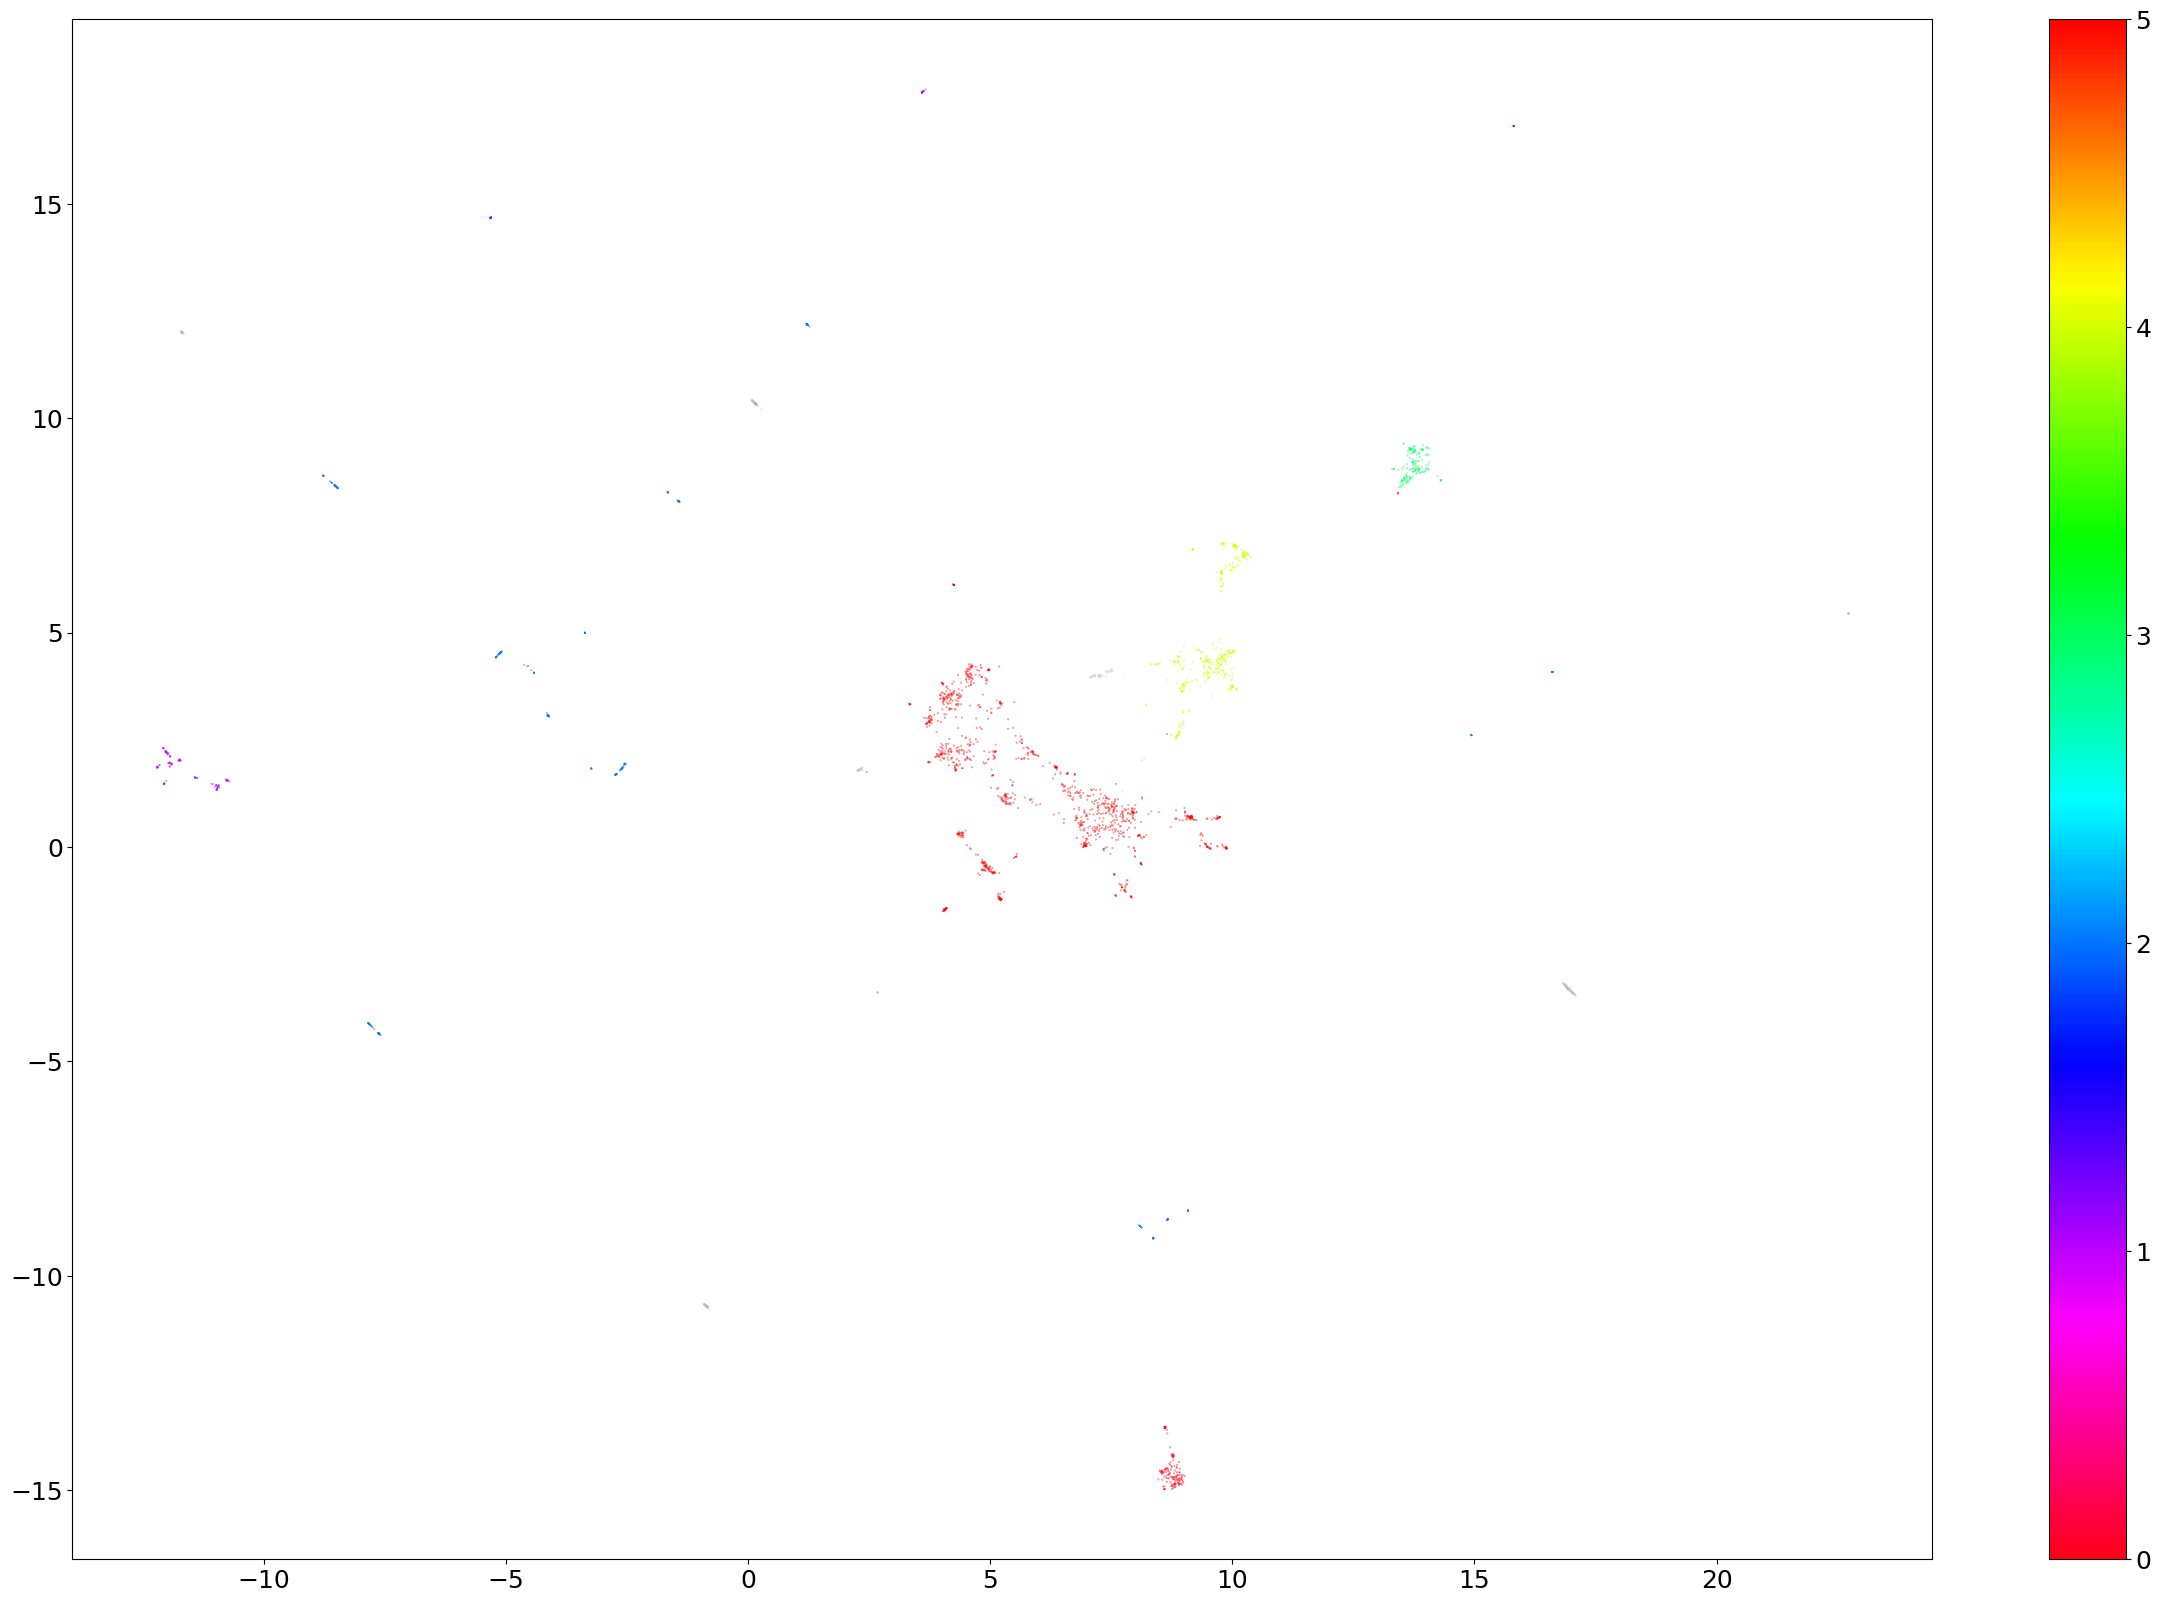

In [71]:
def plot_clusters(data_2d, cluster_labels):
    result = pd.DataFrame(data_2d, columns=['x', 'y'])
    result['labels'] = cluster_labels
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.figure()
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, 
                cmap='hsv_r')
    plt.colorbar()

plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams.update({'font.size': 18})
plot_clusters(umap_2d, model.labels_)

In [72]:
def class_tf_idf_topic_creation(df, cluster_labels, n=10, max_df=1.0):
    m = len(df)
    class_df = pd.DataFrame(df['analysis_text'].values, columns=['analysis_text'])
    class_df['class'] = cluster_labels
    class_df['ID'] = range(len(class_df))
    class_df = class_df[class_df['class'] != -1]
    sent_per_class = class_df.groupby(['class'], 
                                      as_index=False).agg({'analysis_text': ' '.join})
    count = CountVectorizer(stop_words='english', 
                            max_df=max_df).fit(sent_per_class['analysis_text'].values)
    t = count.transform(sent_per_class['analysis_text'].values).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    words = count.get_feature_names_out()
    classes = list(sent_per_class['class'])
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) \
                           for j in indices[i]][::-1] \
                   for i, label in enumerate(classes)}
    return top_n_words

top_n_words = class_tf_idf_topic_creation(df_1, model.labels_)
top_n_words

{0: [('lps', 0.2950958055377575),
  ('lp', 0.08981674428524535),
  ('mes', 0.07408237513644907),
  ('school', 0.06612976836490006),
  ('gaon', 0.045289078652639446),
  ('chapori', 0.04513706167476264),
  ('2021', 0.045051186235464585),
  ('22', 0.04488149589865833),
  ('bohikhowa', 0.03077724956745484),
  ('govt', 0.029767717137809464)],
 1: [('lac', 0.1371777249927025),
  ('hajo', 0.13285388133929743),
  ('pwss', 0.11346289914486907),
  ('renovation', 0.11346289914486907),
  ('sub', 0.11159951139838235),
  ('jalukbari', 0.10495501597971717),
  ('phe', 0.10411848248192765),
  ('repairing', 0.09682402911719896),
  ('2022', 0.09458341451803995),
  ('division', 0.07516463231560437)],
 2: [('canal', 0.07796716426597537),
  ('fis', 0.0660849859622123),
  ('repair', 0.062489366017430756),
  ('pahumara', 0.05137694139617901),
  ('brick', 0.04956266521455506),
  ('main', 0.048796232247319674),
  ('year2020', 0.0486116953285449),
  ('b1canal', 0.04829054212377862),
  ('lined', 0.048290542123778